# 数値流体ゼミ第10回（多分）
# 第6章　圧縮性流れの数値計算法その１（システム方程式の数値計算法）
<br />
<center>担当：川村岳
<center>2021年7月7日

**前回やったこと**：

圧縮性流れの支配方程式である**システム方程式**を導出し，未知変数が入り組んだ微分方程式群を個別のスカラー方程式に分解することができた

**これからやること**：

4章までで学んだスカラー方程式の数値計算法を応用し，システム方程式を解く

システム方程式再掲
\begin{align}
\vec{Q}_t + \vec{E}_x = 0
\end{align}

\begin{align}
\vec{Q} = 
\begin{bmatrix}
\rho \\
\rho u \\
e \\
\end{bmatrix},\ \ \ 
\vec{E} = 
\begin{bmatrix}
\rho u \\
p + \rho u^2 \\
(e + p)u\\
\end{bmatrix}
\end{align}

上から質量保存，運動量保存，エネルギー保存の式になっている．

以下~めんど~簡単のため$\vec{Q}$や$\vec{E}$を$Q$や$E$と書く．

## 6.1 旧来法（1980年代までの計算法）

### (1) Lax法
[スカラー方程式]
\begin{align*}
q^{n+1}_j = \dfrac{1}{2} (q^n_{j+1}+q^{n}_{j-1})-\dfrac{c}{2}\left(\dfrac{\Delta t}{\Delta x}\right)(q^n_{j+1}-q^n_{j-1})
\end{align*}

[システム方程式]
\begin{align}
Q^{n+1}_j = \dfrac{1}{2}(Q^n_{j+1}+Q^n_{j-1})-\dfrac{1}{2}\left(\dfrac{\Delta t}{\Delta x}\right)(E^n_{j+1}-E^n_{j-1})
\end{align}

### (2) L-W法（Lax-Wendroff法）
[スカラー方程式]
\begin{align*}
q^{n+1}_j = q^n_j-\dfrac{c}{2}\left(\dfrac{\Delta t}{\Delta x}\right)(q^n_{j+1}-q^n{j_1})+\dfrac{c^2}{2}\left(\dfrac{\Delta t}{\Delta x}\right)^2(q^n_{j+1}-2q^n_j+q^n_{j-1})
\end{align*}

[システム方程式]
\begin{align}
Q^{n+1}_j=Q^n_j-\dfrac{1}{2}\left(\dfrac{\Delta t}{\Delta x}\right)(E^n_{j+1}-E^n_{j-1})+\dfrac{1}{2}\left(\dfrac{\Delta t}{\Delta x}\right)^2(A_{j+1/2}(E^n_{j+1}-E^n_j)-A_{j-1/2}(E^n_j-E^n_{j-1}))
\end{align}

$A$は流速ヤコビアン行列$A=\dfrac{\partial E}{\partial Q}$

**L-W法は流速ヤコビアン行列の行列積の演算が入るため，計算量的・プログラミング的に大変
→簡素化する（以下2つ）**

### (3) 2段階L-W法
\begin{align}
\left\{
\begin{array}
qQ^{n+1/2}_{j+1/2}=\dfrac{1}{2}(Q^n_{j+1}+Q^n_j)-\dfrac{1}{2}\left(\dfrac{\Delta t}{\Delta x}\right)(E^n_{j+1}-E^n_j) \\
Q^{n+1}_j=Q^n_j-\left(\dfrac{\Delta t}{\Delta x}\right)(E^{n+1/2}_{j+1/2}-E^{n+1/2}_{j-1/2})
\end{array}
\right.
\end{align}

### (4) MacCormack法
\begin{align}
\left\{
\begin{array}
vQ^*_j=Q^n_j-\left(\dfrac{\Delta t}{\Delta x}\right)(E^n_j-E^n_{j-1}) \\
Q^{n+1}_j=\dfrac{1}{2}(Q^n_j+Q^*_j)-\dfrac{1}{2}\left(\dfrac{\Delta t}{\Delta x}\right)(E^*_{j+1}-E^*_j)
\end{array}
\right.
\end{align}

なんでこれがうまくいくの？

$E^n_j=c\cdot Q^n_j$という仮定のもとで第一式を第二式に代入すると，元の式(4)に帰着することがわかる．

流速ヤコビアン行列Aをcで代替し，線型化していることに相当するはず．

実際は(6)式のままではうまくいかないため，粘性項を加える．
\begin{align}
Q^{n+1}_j&=\overline{Q}^{n+1}_j+\kappa(\overline{Q}^{n+1}_{j-1}-2\overline{Q}^{n+1}_j+\overline{Q}^{n+1}_{j+1}) \\
\kappa&=\epsilon_c\dfrac{\left|\overline{Q}^{n+1}_{j-1}-2\overline{Q}^{n+1}_j+\overline{Q}^{n+1}_{j+1}\right|}{\left|\overline{Q}^{n+1}_{j-1}+2\overline{Q}^{n+1}_j+\overline{Q}^{n+1}_{j+1}\right|}
\end{align}

In [31]:
#MacCormack法による衝撃波管問題の計算
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

jmax = 101
dt = 0.002

#比熱比（エネルギーや密度と圧力との関係に使う）
gamma = 1.4

#高圧部の初期条件
PI = 1.0
RHOI = 1.0
UI = 0.0

#低圧部の初期条件
PE = 0.1
RHOE = 0.1
UE = 0.0

xmin, xmid, xmax = 0.0, 0.5, 1.0
x = np.linspace(xmin, xmax, jmax)

dx = (xmax - xmin) / (jmax - 1)

dtdx = dt / dx

#Qの初期化
def init():
    Q = np.zeros([jmax,3])
    
    Q[x <= xmid, 0] = RHOI
    Q[x <= xmid, 1] = RHOI * UI
    Q[x <= xmid, 2] = (PI / (gamma - 1.0) + 0.5 * RHOI * UI**2)
    
    Q[x > xmid, 0] = RHOE
    Q[x > xmid, 1] = RHOE * UE
    Q[x > xmid, 2] = (PE / (gamma - 1.0) + 0.5 * RHOE * UE**2)
    
    return Q

#クーラン数の計算
#計算が安定に進んでいることを確認する
def calc_CFL(Q):
    rho, rhou, e = Q[:,0], Q[:,1], Q[:,2]
    
    u = rhou / rho
    p = (gamma - 1.0) * (e - 0.5 * rho * u**2)
    
    #cは音速
    c = np.sqrt(gamma * p / rho)
    #右固有値
    sp = c + np.abs(u)
    return max(sp) * dtdx

#Eの計算
#EとQの関係が線型であることを仮定している
def E_flux(Q, E):
    rho, rhou, e = Q[:,0], Q[:,1], Q[:,2]
    
    u = rhou / rho
    p = (gamma - 1.0) * (e - 0.5 * rho * u**2)
    
    E[:,0] = rhou
    E[:,1] = p + rhou * u
    E[:,2] = (e + p) * u
    
def MacCormack(Q, eps_c, nmax, interval=2):
    E = np.zeros([jmax, 3])
    
    for n in range(nmax):
        #intervalごとにクーラン数を計算して表示する
        if n % interval == 0:
            print(f'n = {n : 4d} : CFL = {calc_CFL(Q) : .4f}')
            
        Qs = Q.copy()
        
        #1段階目（(6)式の前半）
        E_flux(Q,E)
        for j in range(1, jmax-1):
            Qs[j] = Q[j] - dtdx * (E[j] - E[j-1])
            
        #2段階目（(6)式の後半）
        E_flux(Qs,E)
        for j in range(1, jmax-2):
            Q[j] = 0.5 * (Q[j] + Qs[j]) - 0.5 * dtdx * (E[j+1] - E[j])
            
        #数値粘性の付与
        Qb = Q.copy()
        for j in range(1, jmax-1):
            D1 = Qb[j-1] - 2.0 * Qb[j] + Qb[j+1]
            D2 = Qb[j-1] + 2.0 * Qb[j] + Qb[j+1]
            k = eps_c * np.linalg.norm(D1) / np.linalg.norm(D2)
            Q[j] += k * D1

In [32]:
eps_c = 0.2
nmax = 100
print_interval = 4

Q = init()
MacCormack(Q, eps_c, nmax, print_interval)

n =    0 : CFL =  0.2366
n =    4 : CFL =  0.3945
n =    8 : CFL =  0.4336
n =   12 : CFL =  0.4475
n =   16 : CFL =  0.4693
n =   20 : CFL =  0.4844
n =   24 : CFL =  0.4894
n =   28 : CFL =  0.4989
n =   32 : CFL =  0.5013
n =   36 : CFL =  0.5059
n =   40 : CFL =  0.5057
n =   44 : CFL =  0.5097
n =   48 : CFL =  0.5067
n =   52 : CFL =  0.5115
n =   56 : CFL =  0.5058
n =   60 : CFL =  0.5118
n =   64 : CFL =  0.5075
n =   68 : CFL =  0.5109
n =   72 : CFL =  0.5086
n =   76 : CFL =  0.5094
n =   80 : CFL =  0.5090
n =   84 : CFL =  0.5075
n =   88 : CFL =  0.5088
n =   92 : CFL =  0.5054
n =   96 : CFL =  0.5082


In [33]:
#厳密解の計算（ここの説明はしません）
Pext = np.zeros([jmax, 3])
Qext = np.zeros([jmax, 3])

GUESS = 1.0
FINC = 0.01
itemax1 = 5000
itemax2 = 500

CI = np.sqrt(gamma * PI / RHOI)
CE = np.sqrt(gamma * PE / RHOE)
P1P5 = PI / PE

GAMI = 1.0 / gamma
GAMF = (gamma - 1.0) / (2.0 * gamma)
GAMF2 = (gamma + 1.0) / (gamma - 1.0)
GAMFI = 1.0 / GAMF

for it1 in range(itemax1):
    for it2 in range(itemax2):
        SQRT1 = (gamma - 1.0) * (CE / CI) * (GUESS - 1.0)
        SQRT2 = np.sqrt(2.0 * gamma * (2.0 * gamma + (gamma + 1.0) * (GUESS - 1.0)))
        FUN = GUESS * (1.0 - (SQRT1 / SQRT2)) ** (-GAMFI)
        DIF = P1P5 - FUN
        
        if np.abs(DIF) <= 0.000002:
            break
        
        if DIF >= 0.0:
            GUESS += FINC
        else:
            GUESS -= FINC
            FINC = 0.5 * FINC
            
    else:
        continue
    
    break

P4P5 = GUESS
P4 = PE * P4P5
P3P1 = P4P5 / P1P5
P3 = P3P1 * PI

R4R5 = (1.0 + GAMF2 * P4P5) / (GAMF2 + P4P5)
RHO4 = RHOE * R4R5
U4 = CE * (P4P5 - 1.0) * np.sqrt(2.0 * GAMI / ((gamma + 1.0) * P4P5 + (gamma - 1.0)))
C4 = np.sqrt(gamma * P4 / RHO4)

R3R1 = P3P1 ** GAMI
RHO3 = RHOI * R3R1 
U3 = 2.0 * CI / (gamma - 1.0) * (1.0 - P3P1 ** GAMF)
C3 = np.sqrt(gamma * P3 / RHO3)
CS =  CE * np.sqrt(0.5 * ((gamma - 1.0) * GAMI + (gamma + 1.0) * GAMI * P4 / PE))

TOT = 0.0
EPST = 1.0e-14
for n in range(nmax):
    TOT = TOT + dt
    rad = dt / dx
    
    x1 = xmid - CI * TOT
    x2 = xmid - (CI - 0.5 * (gamma + 1.0) * U3) * TOT
    x3 = xmid + U3 * TOT
    x4 = xmid + CS * TOT
    
    for j in range(jmax):
        xx = x[j]
        if xx <= x1:
            Qext[j, 0] = RHOI
            Qext[j, 1] = RHOI * UI
            Qext[j, 2] = PI / (gamma - 1.0) + 0.5 * UI * Qext[j, 1]
            Pext[j] = PI
        elif xx <= x2:
            UT = UI + (U3 - UI) / ((x2 - x1) + EPST) * ((xx - x1) + EPST)
            RTRI = (1.0 - 0.5 * (gamma - 1.0) * UT / CI) ** (2.0 / (gamma - 1.0))
            RT = RHOI * RTRI
            PT = RTRI ** gamma * PI
            Qext[j, 0] = RT
            Qext[j, 1] = RT * UT
            Qext[j, 2] = PT / (gamma - 1.0) + 0.5 * UT * Qext[j, 1]
            Pext[j] = PT
            
        elif xx <= x3:
            Qext[j, 0] = RHO3
            Qext[j, 1] = RHO3 * U3
            Qext[j, 2] = P3 / (gamma - 1.0) + 0.5 * U3 * Qext[j, 1]
            Pext[j] = P3
        elif xx <= x4:
            Qext[j, 0] = RHO4
            Qext[j, 1] = RHO4 * U4
            Qext[j, 2] = P4 / (gamma - 1.0) + 0.5 * U4 * Qext[j, 1]
            Pext[j] = P4
        else:
            Qext[j, 0] = RHOE
            Qext[j, 1] = RHOE * UE
            Qext[j, 2] = PE / (gamma - 1.0) + 0.5 * UE * Qext[j, 1]
            Pext[j] = PE

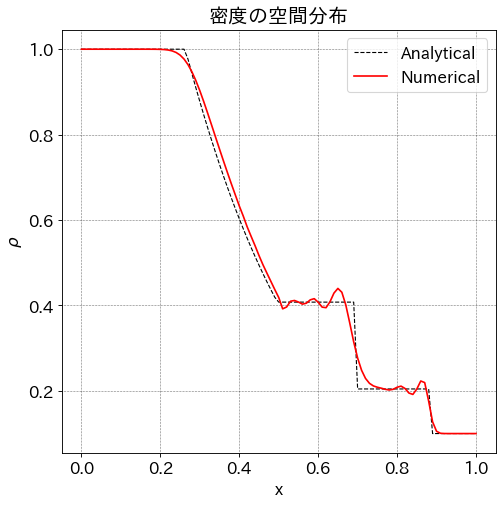

In [34]:
plt.figure(figsize=(7,7), dpi=80)
plt.rcParams["font.size"] = 15
plt.plot(x, Qext[:,0], color='black', linewidth = 1.0, linestyle = 'dashed', label = 'Analytical')
plt.plot(x, Q[:,0], color='red', linewidth = 1.5, label = 'Numerical')
plt.grid(color='black', linestyle='dotted', linewidth=0.5)
plt.xlabel('x')
plt.ylabel(r'$\rho$')
plt.title('密度の空間分布')
plt.legend()
plt.show()

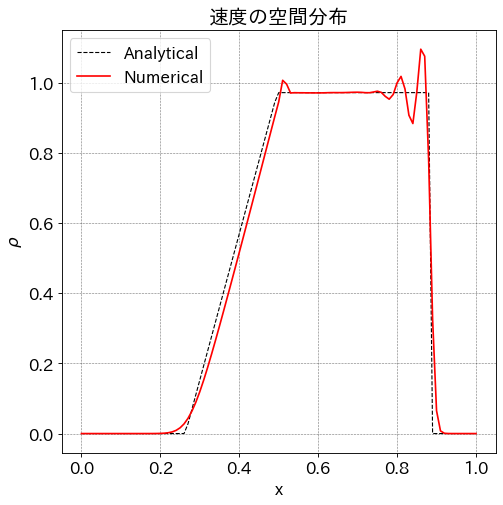

In [35]:
plt.figure(figsize=(7,7), dpi=80)
plt.rcParams["font.size"] = 15
plt.plot(x, Qext[:,1]/Qext[:,0], color='black', linewidth = 1.0, linestyle = 'dashed', label = 'Analytical')
plt.plot(x, Q[:,1]/Q[:,0], color='red', linewidth = 1.5, label = 'Numerical')
plt.grid(color='black', linestyle='dotted', linewidth=0.5)
plt.xlabel('x')
plt.ylabel(r'$\rho$')
plt.title('速度の空間分布')
plt.legend()
plt.show()

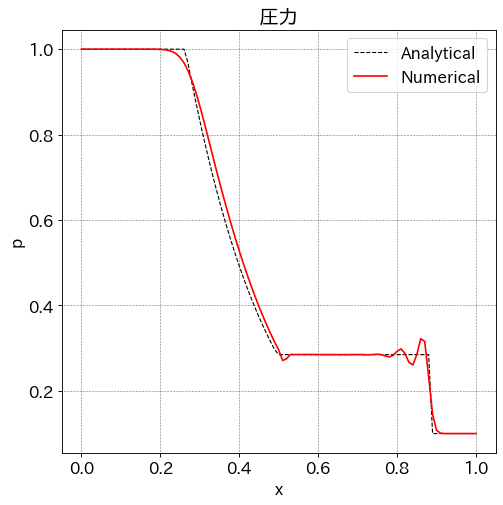

In [36]:
plt.figure(figsize=(7,7), dpi=80)
plt.rcParams["font.size"] = 15
yext = (gamma - 1.0) * (Qext[:,2] - 0.5 * Qext[:,1] ** 2 / Qext[:,0])
y = (gamma - 1.0) * (Q[:,2] - 0.5 * Q[:,1] ** 2 / Q[:,0])
plt.plot(x, yext, color='black', linewidth = 1.0, linestyle = 'dashed',label = 'Analytical')
plt.plot(x, y, color='red', linewidth = 1.5,  label = 'Numerical')
plt.grid(color='black', linestyle='dotted', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('p')
plt.title('圧力')
plt.legend()
plt.show()

3つの特性線が現れているのがわかる

## 6.2 高解像度風上法（TVD法）

より実用的な，一般に普及している手法．スカラー方程式の場合についてはすでに2.8節で見た．

格子セルの境界において左右になんらかの物理量分布があるとする．時間が1ステップ進む進むときに起こる現象を局所的な1次元衝撃波管問題と見れば，そこには圧縮波，接触面，膨張波が生じることになる．TVD法は，この事実を利用して計算する．

TVD法は大きく**FVS法**と**FDS法**に分けられる．さらに，そのそれぞれが**non-MUSCL法**と**MUSCL法**に分かれる．

これからはそれぞれの手法を見ていくことになる．今回はFVS法を扱い，次回FDS法を扱う．

### (1) FVS法（Flux Vector Splitting scheme）の基本的な考え方

**波束ベクトル分離法**とも呼ばれる．固有ベクトル系に分解した状況ならスカラー方程式の手法がそのまま適用できるが，j+1/2などの格子境界領域における固有値や固有ベクトルはどう評価するか？

→素直に考えれば，MUSCL高次内挿（要するに周囲の値のうまい平均）によって決めればよいだろう

### (2) Steger-Warmingの1次精度FVS法

j点での物理量変化を，格子境界における数値流速を用いて以下のように表す．（以降添字nは省略する）
\begin{align}
Q^{n+1}_j=Q^n_j-\left(\dfrac{\Delta t}{\Delta x}\right)(\tilde{E}^n_{j+1/2}-\tilde{E}^n_{j-1/2})\\
\tilde{E}^n_{j+1/2}=E^+_j+E^-_{j+1}=E^+(Q_j)+E^-(Q_{j+1})\\
\tilde{E}^n_{j-1/2}=E^+_{j-1}+E^-_j=E^+(Q_{j-1})+E^-(Q_j)
\end{align}

+と-はそれぞれ左と右からの流速を表している．ただしスカラー方程式の場合と違い，固有値の符号次第で右から来る情報と左から来る情報は混在しうる．

#### $E^+$や$E^-$の具体的な計算方法

流速$E_j$は$Q_j$と流速ヤコビアン行列により$E_j=A_jQ_j$と表される．5章の議論に従い，$A_j$を対角化して$A_j=R_i\Lambda_jR^{-1}_j$と分解し，情報の伝播方向（固有値の符号）にしたがって以下のように分解する．

\begin{align}
\Lambda_j&=\Lambda^+_j+\Lambda^-_j \\
\Lambda^+ &= 
\begin{pmatrix}
\dfrac{u-c+|u-c|}{2} & 0 & 0 \\
0 & \dfrac{u+|u|}{2} & 2 \\
0 & 0 & \dfrac{u+c+|u+c|}{2} \\
\end{pmatrix} \\
\Lambda^- &=
\begin{pmatrix}
\dfrac{u-c-|u-c|}{2} & 0 & 0 \\
0 & \dfrac{u-|u|}{2} & 2 \\
0 & 0 & \dfrac{u+c-|u+c|}{2} \\
\end{pmatrix} \\
R &=
\begin{pmatrix}
1 & 1 & 1 \\
u-c & u & u+c \\
H-uc & \dfrac{1}{2}u^2 & H+uc \\
\end{pmatrix}
\end{align}
ただし$H$は単位質量あたりのエンタルピー．

これらを利用すれば，

\begin{align}
E^+=(R_j\Lambda^+_jR^{-1}_j)Q_j \\
E^-=(R_j\Lambda^-_jR^{-1}_j)Q_j
\end{align}

によって左右それぞれからの波束を計算できる．毎回この計算をするのは大変であるため，実際にはあらかじめ$A^+_j$などの演算を作っておく．

以上まとめておくと

\begin{align}
\tilde{E}_{j+1/2}&=E^+_j+E^-_{j+1}=A^+_jQ_j+A^-_{j+1}Q_{j+1} \\
&=\dfrac{A_j+|A_j|}{2}Q_j+\dfrac{A_{j+1}-|A_{j+1}|}{2}Q_{j+1} \\
&=\dfrac{1}{2}(E_j+E_{j+1}-(|A_{j+1}|Q_{j+1}-|A_j|Q_j))
\end{align}

### (3) Steger-Warmingの2次精度FVS法

FVS法の高次精度化は2.5節の議論と同様に考えられ，式(10)と(11)を以下のように修正する．

\begin{align}
\tilde{E}_{j+1/2}=E^+_{L,j+1/2}+E^-_{R,j+1/2}=E^+(Q_{L,j+1/2})+E^-(Q_{R,j+1/2}) \\
\tilde{E}_{j-1/2}=E^+_{L,j-1/2}+E^-_{R,j-1/2}=E^+(Q_{L,j-1/2})+E^-(Q_{R,j-1/2})
\end{align}

FVS法の考え方では以上で問題ないのだが，この方法は固有値の符号が変化する音速点で流束が微分可能でなくなるという問題があった．そこで提案されたのが以下の方法である．

### (4) van LeerのFVS法（1次精度および高次精度）

$E^{\pm}$を以下のように修正する

\begin{align}
E^{\pm}=\dfrac{\rho c}{4}(M\pm1)^2
\begin{bmatrix}
1 \\
\dfrac{2c}{\gamma}\left(\pm1+\dfrac{\gamma-1}{2}M\right) \\
\dfrac{2c^2}{\gamma^2-1}\left(1\pm\dfrac{\gamma-1}{2}M\right)^2 \\
\end{bmatrix}
\end{align}

Mは局所的なマッハ数．$M\pm1$を$u\pm c$の形にすればSteger-Warmingの$E^{\pm}$と同等であることがわかる．

ただし，解の単調性を維持しつつ高次精度化するためには$j\pm 1/2$での数値流速評価の際に流速制限関数を導入することが必要→MUSCL法

### (5) MUSCL内挿について

MUSCL内挿により，(2)における$E^+_j$や$E^-_{j+1}$を$E_{L,j+1/2}$や$E_{R,j+1/2}$に，$E^+_{j-1}$や$E^-_{j-1}$を$E_{L,j-1/2}$や$E_{R,j-1/2}$に置き換える．

その際に物理量$Q$のMUSCL内挿による表式

\begin{align}
(Q_L)_{j+1/2}&=Q_j+\dfrac{\epsilon}{4}((1-\kappa)\tilde{\Delta}_-+(1+\kappa)\tilde{\Delta}_+)_j \\
(Q_R)_{j+1/2}&=Q_{j+1}-\dfrac{\epsilon}{4}((1-\kappa)\tilde{\Delta}_++(1+\kappa)\tilde{\Delta}_-)_{j+1}
\end{align}

$\tilde{\Delta}_+$や$\tilde{\Delta}_-$は$(\tilde{\Delta}_+)_j=Q_{j+1}-Q_j$，$(\tilde{\Delta}_-)_j=Q_j-Q_{j-1}$に対し制限関係を導入した結果である（2.8節と同様）．